In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from gensim.test.utils import common_texts
from gensim.models import Word2Vec,word2vec
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt  

In [2]:
def show_train_acc_history(train, val):
    plt.figure()
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[val])
    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

    

def show_train_loss_history(train, val):
    plt.figure()
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[val])
    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()  

In [3]:
test = pd.read_csv("test.csv", delimiter="\t")#,error_bad_lines=False
train = pd.read_csv("train.csv", delimiter="\t")#,error_bad_lines=False
sub = pd.read_csv("sample_submission.csv").dropna(how='all', axis=1)
train= train.drop([1615])
value_list = [row[0] for row in train.itertuples(index=False, name=None)]#tainx
label = [row[1] for row in train.itertuples(index=False, name=None)]#trainy
ans = [row[1] for row in sub.itertuples(index=False, name=None)]#testy
test_list = [row[1] for row in test.itertuples(index=False, name=None)]#testx


new_numbers = []
for n in label:
    new_numbers.append(int(n))
label = new_numbers

In [4]:
import nltk
nltk.download('stopwords')
nltk_stopwords = nltk.corpus.stopwords.words('english')

import spacy

nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
"""
#stop_words=['the', 'a','and','an','he','she','her','him','his']
cv = CountVectorizer(max_df=1.0, min_df=1, max_features=None,stop_words=nltk_stopwords)#(max_df=0.95, min_df=2,
#統計每個詞語的tf-idf權值
cv = cv.fit_transform(value_list)
"""
filtered_word_list = value_list[:] #make a copy of the word_list
for i in range(len(filtered_word_list)): # iterate over word_list
    filtered_word_list[i] = [word for word in filtered_word_list[i].split() if word not in nltk_stopwords]

filtered_test_list = test_list[:] #make a copy of the word_list
for i in range(len(filtered_test_list)): # iterate over word_list   
    filtered_test_list[i] = [word for word in filtered_test_list[i].split() if word not in nltk_stopwords]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
model = word2vec.Word2Vec(sentences=common_texts, window=5, min_count=1, workers=4)#vector_size=100,
#model = word2vec.Word2Vec(sentences, size=5, min_count=1, negative=10)
model.save("word2vec.model")
model = Word2Vec.load("word2vec.model")

#x_train = cv.fit_transform(value_list)
#To train Word2Vec it is better not to remove stop words because the algorithm relies on the broader context of the sentence in order to produce high-quality word vectors
model.train(value_list, total_examples=1, epochs=1)

#vector = model.wv['computer']
word_vectors = model.wv



In [6]:
#建立Token
token = Tokenizer(num_words=3800) 
#使用Tokenizer模組建立token，建立一個3800字的字典
token.fit_on_texts(filtered_word_list)  
#讀取所有訓練資料，依照每個英文字在訓練資料出現的次數進行排序，
#前3800名的英文單字會加進字典中
token.word_index
#可以看到它將英文字轉為數字的結果，例如:the轉換成1

x_train_seq = token.texts_to_sequences(filtered_word_list)
x_test_seq = token.texts_to_sequences(filtered_test_list)
#透過texts_to_sequences可以將訓練和測試集資料中的文字轉換為數字list

x_train = sequence.pad_sequences(x_train_seq, maxlen=380)
x_test = sequence.pad_sequences(x_test_seq, maxlen=380)
#長度小於380的，前面的數字補0
#長度大於380的，截去前面的數字


In [7]:
transformer = TfidfTransformer()
#第一個fit_transform是計算tf-idf，第二個fit_transform是將文本轉詞本矩陣
x_traint = transformer.fit_transform(x_train) 
x_testt  = transformer.transform(x_test) #匯入模組


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 380, 32)           121600    
_________________________________________________________________
dropout (Dropout)            (None, 380, 32)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 16)                784       
_________________________________________________________________
dense (Dense)                (None, 256)               4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 126,993
Trainable params: 126,993
Non-trainable params: 0
__________________________________________________

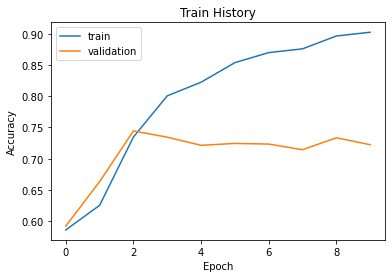

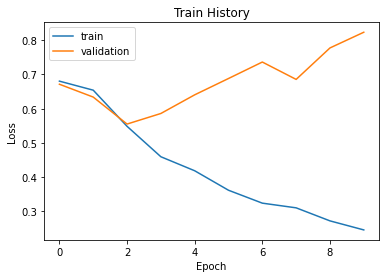

39/39 [==============================] - 0s 10ms/step - loss: 1.6457 - accuracy: 0.4916
[1.645721197128296, 0.4915798008441925]
accuracy =  0.4915798008441925


In [8]:
from keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation,Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN

#建立Keras的Sequential模型
modelRNN = Sequential()  #建立模型
#Embedding層將「數字list」轉換成「向量list」
modelRNN.add(Embedding(output_dim=32,   #輸出的維度是32，希望將數字list轉換為32維度的向量
     input_dim=3800,  #輸入的維度是3800，也就是我們之前建立的字典是3800字
     input_length=380)) #數字list截長補短後都是380個數字

#加入Dropout，避免overfitting
modelRNN.add(Dropout(0.7)) 	#隨機在神經網路中放棄70%的神經元，避免overfitting

#建立RNN層
modelRNN.add(SimpleRNN(units=16))
 #建立16個神經元的RNN層

#建立隱藏層
modelRNN.add(Dense(units=256,activation='relu')) 
#建立256個神經元的隱藏層
#ReLU激活函數
modelRNN.add(Dropout(0.7))

#建立輸出層
modelRNN.add(Dense(units=1,activation='sigmoid'))
#建立一個神經元的輸出層
#Sigmoid激活函數

#查看模型摘要
modelRNN.summary()
#定義訓練模型
modelRNN.compile(loss='binary_crossentropy',
     optimizer='adam',
     metrics=['accuracy']) 
#import torch   pip uninstall torch
#train_history = modelRNN.fit(outputs, torch.Tensor(label), 
#xxx = outputs.numpy()#outputs.numpy().astype(np.int32)
train_history = modelRNN.fit(x_train, np.array(label), 
         epochs=10,#10 
         batch_size=100,
         verbose=2,
         validation_split=0.2)#,callbacks=ModelCheckpoint("model_{binary_accuracy}.hdf5") 

#validation_split =0.2 設定80%訓練資料、20%驗證資料
#執行10次訓練週期
#每一批次訓練100筆資料
#verbose 顯示訓練過程

show_train_acc_history('accuracy', 'val_accuracy') 
show_train_loss_history('loss', 'val_loss')

scores = modelRNN.evaluate(x_test,  np.array(ans),verbose=1)#x_test.A
print(scores)
print("accuracy = ",scores[1])
#使用test測試資料及評估準確率


In [9]:
from keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation,Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM

modelLSTM = Sequential() #建立模型

modelLSTM.add(Embedding(output_dim=32,   #輸出的維度是32，希望將數字list轉換為32維度的向量
     input_dim=3800,  #輸入的維度是3800，也就是我們之前建立的字典是3800字
     input_length=380)) #數字list截長補短後都是380個數字



modelLSTM.add(Dropout(0.7)) #隨機在神經網路中放棄70%的神經元，避免overfitting

#建立LSTM層
modelLSTM .add(LSTM(32)) 
#建立32個神經元的LSTM層

#建立隱藏層
modelLSTM.add(Dense(units=256,activation='relu')) 
#建立256個神經元的隱藏層
modelLSTM.add(Dropout(0.7))

#建立輸出層
modelLSTM.add(Dense(units=1,activation='sigmoid'))
 #建立一個神經元的輸出層
#查看模型摘要
modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 380, 32)           121600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 380, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 138,625
Trainable params: 138,625
Non-trainable params: 0
________________________________________________

Epoch 1/10
40/40 - 6s - loss: 0.6790 - accuracy: 0.5935 - val_loss: 0.6708 - val_accuracy: 0.5922
Epoch 2/10
40/40 - 6s - loss: 0.6354 - accuracy: 0.6344 - val_loss: 0.6018 - val_accuracy: 0.6764
Epoch 3/10
40/40 - 6s - loss: 0.4948 - accuracy: 0.7691 - val_loss: 0.5636 - val_accuracy: 0.7224
Epoch 4/10
40/40 - 6s - loss: 0.3902 - accuracy: 0.8265 - val_loss: 0.5683 - val_accuracy: 0.7305
Epoch 5/10
40/40 - 6s - loss: 0.3237 - accuracy: 0.8679 - val_loss: 0.6162 - val_accuracy: 0.7265
Epoch 6/10
40/40 - 6s - loss: 0.2877 - accuracy: 0.8877 - val_loss: 0.6824 - val_accuracy: 0.7325
Epoch 7/10
40/40 - 6s - loss: 0.2501 - accuracy: 0.9035 - val_loss: 0.7766 - val_accuracy: 0.7315
Epoch 8/10
40/40 - 6s - loss: 0.2265 - accuracy: 0.9120 - val_loss: 0.8030 - val_accuracy: 0.7285
Epoch 9/10
40/40 - 5s - loss: 0.1976 - accuracy: 0.9253 - val_loss: 0.9092 - val_accuracy: 0.7305
Epoch 10/10
40/40 - 6s - loss: 0.1809 - accuracy: 0.9318 - val_loss: 0.9356 - val_accuracy: 0.7285
39/39 [============

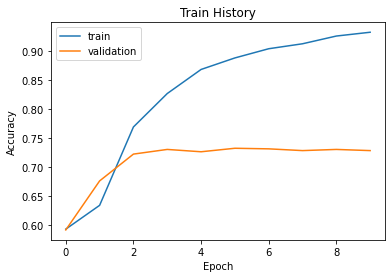

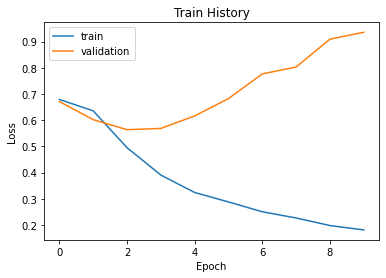

In [10]:
#訓練模型參數同RNN
modelLSTM.compile(loss='binary_crossentropy',
     optimizer='adam',
     metrics=['accuracy']) 

train_history = modelLSTM.fit(x_train, np.array(label), 
         epochs=10, 
         batch_size=100,
         verbose=2,
         validation_split=0.2)


#評估模型準確率
scores = modelLSTM.evaluate(x_test,  np.array(ans),verbose=1)
print(scores)
print("accuracy = ",scores[1])

show_train_acc_history('accuracy', 'val_accuracy') 
show_train_loss_history('loss', 'val_loss')

